# Bag-of-Words for Document Classification

## Data and problem statement

We consider a situation where a list of English language documents are given and a class to which each of these belongs. We would like to extract a set of features from each document (in a consistent manner) and to choose a classification model to train on these data. As always, we need to split our data into train, validation and test partition or apply k-fold cross validation. In this training we will simplify by simply splitting this documents list at random into train and test parts (0.70 train and 0.30 test).

> For this training you'll need the *uci-news-aggregator.csv* dataset from [this kaggle project](https://www.kaggle.com/uciml/news-aggregator-dataset). You'll need to download it if you don't have it already.

In [2]:
import pandas as pd
text_df = pd.read_csv("~/workspace/data/uci-news-aggregator.csv")

# Some properties of our data
print("Columns:", text_df.columns.tolist())
print("Dimensions:", text_df.shape)

text_df.groupby("CATEGORY").size()

Columns: ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
Dimensions: (422419, 8)


CATEGORY
b    115967
e    152469
m     45639
t    108344
dtype: int64

Now we will limit our document dataset to two classes (b = business, e = entertainment) so that we have a binary classification problem:

In [3]:
text_df = text_df.query("CATEGORY == 'b' | CATEGORY == 'e'")
text_df.groupby("CATEGORY").size()

CATEGORY
b    115967
e    152469
dtype: int64

## Basic text preprocessing with NLTK

Since language is simply too rich to define separate variable for each word form that appears in or documents, we first transform our texts as follows, and thereby reduce number of distinct words.

1. Remove all punctuation signs and digits
2. Cast all letters to lower case
3. Remove words that appear very often (thus are little informative); we use a file from a package where standard list of stop words is found
4. Apply a lematization algorithm; there are many variants and essentially we wish to map e.g. ‘be’, ‘being’, ‘am’ , ‘is’ to a single word ‘be’; likewise ‘element’, ‘elements’, ‘elementary’, ‘elemental’ should be mapped to ‘element’. However ‘news’ should not map to ‘new’ as it is a distinct word. There are many scientific articles about how to do this in English language, and off course less for other languages and the proposed solutions also vary. 

In [4]:
# Run first time to download corpora
# import nltk
# nltk.download("wordnet")

from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
wnl = WordNetLemmatizer()
prt = PorterStemmer()

import string
import re

def clean_text(text):
    # Remove punctuation and digits
    text = re.sub(r'[^A-Za-z\s]','',text)  # Only keep words and whitespace characters
    # Make lower case
    text = text.lower()
    # Split into list for further transformations
    text = text.split(" ")
    # Remove stopwords
    text = [word for word in text if word not in STOPWORDS]
    # Lemmatize and stemming words
    text = [prt.stem(word) for word in text]
    text = [wnl.lemmatize(word) for word in text]
    # Return to string
    text = " ".join(text)
    return text

for title in text_df.TITLE[0:5]:
    print(title)
    print(clean_text(title))
    print("---")

Fed official says weak data caused by weather, should not slow taper
fed offici say weak data caus weather slow taper
---
Fed's Charles Plosser sees high bar for change in pace of tapering
fed charl plosser see high bar chang pace taper
---
US open: Stocks fall after Fed official hints at accelerated tapering
open stock fall fed offici hint acceler taper
---
Fed risks falling 'behind the curve', Charles Plosser says
fed risk fall curv charl plosser say
---
Fed's Plosser: Nasty Weather Has Curbed Job Growth
fed plosser nasti weather curb job growth
---


## Creating binary features from documents

A human typed text is a rich representation of information which essentially requires human level of intelligence to fully understand. In particular order of words, punctuation signs, and exact grammatical forms in which words are used gives many different flavours to a piece of text. However we are only interested to separate a list of documents in two piles-one of class 0 and the other of class 1.

**Simplest approach one can take is to define one binary variable for each word that appears in any of the documents that we have to work with in this problem, in such way that if that word appears in a given document, then this feature has value 1 and of it does not appear then it has value 0.**

In this approach, if a word appears more than once, then the corresponding feature still has value 1. Also, the order of the words does not influence the extracted feature values, and also punctuation signs are disregarded all together (in fact we will remove them at the beginning of our processing).

As example ‘Story was telling about a data scientist’ and ‘Data scientist was telling a story about data’ will have exactly the same feature values sequence. As inadequate as this may seem, if the goal is to find documents about data scientists then it might in fact work well enough.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer="word", 
                             binary=True,
                             preprocessor=clean_text)

tdm = vectorizer.fit_transform(text_df.TITLE)

print(vectorizer.get_feature_names()[0:10])
print(len(vectorizer.get_feature_names()))

['aa', 'aaa', 'aaaa', 'aaaarrrrrghhh', 'aaah', 'aal', 'aaliyah', 'aamc', 'aan', 'aap']
34402


## Naive Bayes Classifier with binary features

One of the most simple types of machine learning models that is suitable here is the so called Naïve Bayes model. The simplest form of this model is of the binary classification type. There we assume that each observation consists of a vector of binary valued features $X=(x_1,x_2,…,x_k)$ (each component $x_j$ is either 0 or 1 valued) and a binary target value $Y$. By the basic Bayes theorem we have that

\begin{align*} P(Y \mid x_1,x_2,...,x_k) &= \frac{P(Y)\ P(x_1,x_2,...,x_k \mid Y)}{P(x_1,x_2,...,x_k)} \\
&= \frac{P(Y)\ P(x_1,x_2,...,x_k \mid Y)}{P(x_1,x_2,...,x_k\mid Y = 0)\ P(Y=0) + P(x_1,x_2,...,x_k\mid Y = 1)\ P(Y=1)}\end{align*}

Here $X=(x_1,x_2,…,x_k)$ is a binary valued sequence of feature values for a given observation. In this case we 'only' need to estimate probabilities $P(Y=1)$, $P(Y=0)$, and $P(x_1,x_2,…,x_k|Y=0)$, $P(x_1,x_2,…,x_k|Y=1)$ for each possible binary sequence $x_1,x_2,...,x_k$ of feature values. Now for a feature vector of length $k$, there are $2^k$ distinct binary sequences of length $k$ (in each position we can have 0 or 1, so we indeed have to take k-th power of 2). So total number of parameters to estimate is $2\cdot2^k +2$ = 'waaay too many!'.

To get a feeling of this number, if we have many features, say as many as there are different words in a list of documents, of we would work with 200 different words, then $2^{200}=16^{50}$ which is a number larger then number of atoms in the universe! Also, Some of these combinations of binary values are typically very rare in our data which amounts to very low significance (certainty) of our estimate, and that translates directly to low predictive performance of our model.

## Reducing number of parameters

A way to mitigate a too high number of parameters to estimate is the so called Naïve Bayes assumption.  We thus assume that

$$ P(x_1,x_2,...,x_k \mid Y=0) = \prod_{i=1}^{k}P(x_i \mid Y=0)$$

and

$$ P(x_1,x_2,...,x_k \mid Y=1) = \prod_{i=1}^{k}P(x_i \mid Y=1)$$

for each sequence of binary values $x_1, x_2, …, x_k$.

This greatly reduces the number of probabilities we need to estimate, now only $k$ for $p(x_1,x_2,...,x_k)$. This means a total of $2\cdot k + 2$, for a total speedup of $\frac{2\cdot k + 2}{2 \cdot 2^k + 2}$. This speedup as a function of $k$ is plotted below:

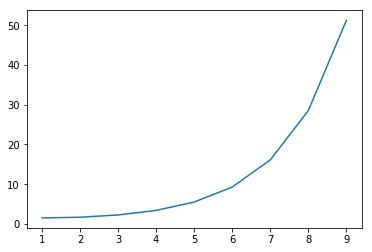

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1,10)
plt.plot(x, (2*2**x + 2)/(2*x + 2))

We can estimate these probabilities using a maximum likelihood estimator, which gives us the following estimators:

$$p^i_{1,0} = P(x_i=1\mid Y=0) := \frac{\#\{\text{observations with $x_i = 1$ and $y = 0$}\} + 1}{\#\{\text{observations with $Y=0$}\} + 2}$$

$$p^i_{0,0} = P(x_i=0\mid Y=0) := \frac{\#\{\text{observations with $x_i = 0$ and $y = 0$}\} + 1}{\#\{\text{observations with $Y=0$}\} + 2}$$

$$ p^i_{0,1} = P(x_i=0\mid Y=1) := \frac{\#\{\text{observations with $x_i = 0$ and $y = 1$}\} + 1}{\#\{\text{observations with $Y=1$}\} + 2}.$$

$$ p^i_{1,1} = P(x_i=1\mid Y=1) := \frac{\#\{\text{observations with $x_i = 1$ and $y = 1$}\} + 1}{\#\{\text{observations with $Y=1$}\} + 2}.$$

and

$$ q^0 = P(Y=0) := \frac{\#\{\text{observations with $Y = 0$}\} + 1}{\#\{\text{total observations}\} + 2}.$$

$$ q^1 = P(Y=1) := \frac{\#\{\text{observations with $Y = 1$}\} + 1}{\#\{\text{total observations}\} + 2}.$$

Since this is binary classification, we could also calculate some of these probabilites by using $p^i_{0,0} = 1 - p^i_{1,0}$. We show the complete calculations above as this more easily generalizes to non-binary classification.

> *Note that we add 1 to the numerator and 2 to the denominator. This is what's called Laplace smoothing, which improves the estimator's accuracy and makes it more robust. You can read more about it [here](https://www.wikiwand.com/en/Additive_smoothing).*


Although above we show how each individual $p^i_{1,0}$ is calculated, it is easier to calculate the vector 

$$p_{1,0} = \big(p^1_{1,0}, p^2_{1,0}, ..., p^k_{1,0}\big)$$

where $p^i_{1,0} = P(x_i = 1 \mid Y=0)$. The same counts for the other probabilities $p^i_{0,1}, q^0,$ etc...

## How to classify a new documents

Say we have a new out-of-sample title we want to classify. The feature vector associated with sentence (after all the necessary cleaning steps) is $X = (x_1,x_2,...,x_k)$, where $x_i = 1$ if the $i$-th word is in the new sentence, and $x_i = 0$ if not. We can then calculate the new probability using:

$$ P(Y = 1 \mid x_1,...,x_k) = \frac{q^1\cdot \left(\prod_{i=1}^{k}p^i_{x_i,1}\right)}{q^0\cdot \left(\prod_{i=1}^{k}p^i_{x_i,0}\right) + q^1\cdot \left(\prod_{i=1}^{k}p^i_{x_i,1}\right)}$$

Now to calculate this probability, we will use an example sentence valued `title = "President trump actually launched a nuclear missile at the moon. We're doomed!"`. We will use the shorter vector notation $p_{0,0}$ and $q^0$ mentioned earlier, as this works nicely with numpy arrays.

In [17]:
target = text_df.CATEGORY == "b"

p10 = ((tdm == 1).sum(axis=0) + 1)/(sum(target == False) + 2)
p10 = np.asarray(p10).flatten()
p00 = 1 - p10
p11 = ((tdm == 1).sum(axis=0) + 1)/(sum(target == True) + 2)
p11 = np.asarray(p11).flatten()
p01 = 1 - p11
q0 = sum(target == False)/len(target)
q1 = 1 - q0

# We'll convert our sentence to it's binary feature vector first
title1 = "President trump actually launched a nuclear missile at the moon. We're doomed!"
title2 = "The dow jones market is crashing. Bonds and stocks are free-falling."
sentences = [title1, title2]
bin_features = vectorizer.transform(sentences)
for i in range(len(sentences)):
    row = bin_features.getrow(i)
    print(row.indices)
    print([vectorizer.get_feature_names()[i] for i in row.indices])

[  229  8262 16864 19331 19640 21088 23726 31171]
['actual', 'doom', 'launch', 'missil', 'moon', 'nuclear', 'presid', 'trump']
[ 3400  6565  8353 11142 15777 18238 28980]
['bond', 'crash', 'dow', 'freefal', 'jone', 'market', 'stock']


We can see that our text was properly preprocessed, and we now have our sentence's feature vector. Lets get to calculated it's probability. We'll first calculate the $q^1\cdot \left(\prod_{i=1}^{k}p^i_{x_i,1}\right)$ term:

In [25]:
# These are the probability terms for x_i = 1 and x_i = 0

n = len(sentences)
        
pxy1 = np.zeros(n)
pxy0 = np.zeros(n)

for i in range(len(sentences)):
    vec = bin_features.getrow(i)
    pxy1[i] = q1*np.prod(p11[vec.indices])*np.prod(np.delete(p01,vec.indices))
    pxy0[i] = q0*np.prod(p10[vec.indices])*np.prod(np.delete(p00,vec.indices))

print(pxy1,pxy0)
print(pxy1/(pxy0+pxy1))

[9.40285414e-31 1.51899734e-23] [5.53517927e-30 1.14537315e-22]
[0.1452074  0.11709158]


As you can see, the individual probabilities are quite small. For larger dictionaries Luckily some creative minds came up with as solution to this problem. Have a look at [this stackexchange post](https://stats.stackexchange.com/questions/105602/example-of-how-the-log-sum-exp-trick-works-in-naive-bayes) for a great explanation. We instead calculate the following, which avoids the issues of numerical underflow using the magic of logarithms:

$$\log\big(P(Y=1\mid x_1,...,x_k)\big) = \log\left(q^1\right) + \sum_{i=1}^k\log\left(p_{x_i,1}^i\right) - M$$

with

$$ M = A + \log\left(e^{\log\left(q_0\right) + \sum_{i=1}^k\log\left(p^i_{x_i,0}\right) - A} + e^{\log\left(q_1\right) + \sum_{i=1}^k\log\left(p^i_{x_i,1}\right) - A}\right)$$

where we take $A:= \max\left(\log\left(q_0\right) + \sum_{i=1}^k\log\left(p^i_{x_i,0}\right), \log\left(q_1\right) + \sum_{i=1}^k\log\left(p^i_{x_i,1}\right)\right)$. Let's try this out and see if we are able to avoid the underflow issue we had before.

In [32]:
# We use logpxy1 = log( P(x_1,...,x_k | Y = 1) )
n = len(sentences)
        
logpxy1 = np.zeros(n)
logpxy0 = np.zeros(n)
A = np.zeros(n)

for i in range(len(sentences)):
    vec = bin_features.getrow(i)
    logpxy1[i] = np.log(q1) + np.sum(np.log(p11[vec.indices])) + np.sum(np.log(np.delete(p01,vec.indices)))
    logpxy0[i] = np.log(q0) + np.sum(np.log(p10[vec.indices])) + np.sum(np.log(np.delete(p00,vec.indices)))

A = np.maximum(logpxy0,logpxy1)
M = A + np.log(np.exp(logpxy0 - A) + np.exp(logpxy1 - A))
py1x = np.exp(logpxy1 - M)
print(py1x)

[0.1452074  0.11709158]


Great, so we can see that it returns the same probabilities as when we calculated without the log-sum-exp trick. Now lets combine all the work we've done so far into a Naive Bayes Classifier class, which we can use in the future.

In [36]:
class BinaryClassifier:

    def clean_text(text):
        # Remove punctuation and digits
        text = re.sub(r'[^A-Za-z\s]','',text)  # Only keep words and whitespace characters
        # Make lower case
        text = text.lower()
        # Split into list for further transformations
        text = text.split(" ")
        # Remove stopwords
        text = [word for word in text if word not in STOPWORDS]
        # Lemmatize and stemming words
        text = [prt.stem(word) for word in text]
        text = [wnl.lemmatize(word) for word in text]
        # Return to string
        text = " ".join(text)
        return text

    
    def fit(self, doc_list, target):
        
        self.vectorizer = CountVectorizer(analyzer="word", 
                                          binary=True,
                                          preprocessor=clean_text)
        
        tdm = self.vectorizer.fit_transform(doc_list)
        
        self.p10 = ((tdm == 1).sum(axis=0) + 1)/(sum(target == False) + 2)
        self.p10 = np.asarray(p10).flatten() # Convert matrix to 1darray
        self.p00 = 1 - self.p10
        self.p11 = ((tdm == 1).sum(axis=0) + 1)/(sum(target == True) + 2)
        self.p11 = np.asarray(p11).flatten() # Convert matrix to 1darray
        self.p01 = 1 - self.p11
        self.q0 = sum(target == False)/len(target)
        self.q1 = 1 - self.q0
        
    def predict(self, sentences):
        bin_feat = self.vectorizer.transform(sentences)
        n = len(sentences)
        
        logpxy1 = np.zeros(n)
        logpxy0 = np.zeros(n)
        A = np.zeros(n)

        for i in range(n):
            vec = bin_feat.getrow(i)
            logpxy1[i] = np.log(q1) + np.sum(np.log(p11[vec.indices])) + np.sum(np.log(np.delete(p01,vec.indices)))
            logpxy0[i] = np.log(q0) + np.sum(np.log(p10[vec.indices])) + np.sum(np.log(np.delete(p00,vec.indices)))

        A = np.maximum(logpxy0,logpxy1)
        M = A + np.log(np.exp(logpxy0 - A) + np.exp(logpxy1 - A))
        P = np.exp(logpxy1 - M)
        py1x = np.exp(logpxy1 - M)
        
        return py1x

In [39]:
from sklearn.model_selection import train_test_split

target = text_df.CATEGORY == "b"

X_train, X_test, y_train, y_test = train_test_split(text_df.TITLE, target, test_size=0.3)

binclass = BinaryClassifier()
binclass.fit(X_train, y_train)
y_test_pred = binclass.predict(X_test)

In [51]:
list(zip(y_test_pred,y_test))

[(0.11394396663288946, False),
 (0.14465731227368328, False),
 (0.06922994176428916, True),
 (0.08908864078212606, True),
 (0.06923074005680002, False),
 (0.14460311614221907, False),
 (0.14460311645631366, True),
 (0.11399219173959553, False),
 (0.08916024974167423, False),
 (0.14460209457402076, False),
 (0.03168984938873399, True),
 (0.11395210339786693, False),
 (0.08916599357102596, False),
 (0.06935479188982743, False),
 (0.11394438784570877, True),
 (0.11393291063960935, True),
 (0.14459749768832503, True),
 (0.02428727208829, True),
 (0.08908495485555383, True),
 (0.08909300451773247, False),
 (0.08910574518191353, True),
 (0.18275663645915458, True),
 (0.041253526803202004, False),
 (0.06923167131928276, True),
 (0.06923007481581542, True),
 (0.11393499668988528, True),
 (0.0890846195110242, True),
 (0.06927566590219854, False),
 (0.041321698623589906, True),
 (0.06923499819794006, True),
 (0.08909350778422326, True),
 (0.14461460971728327, False),
 (0.06923965625532069, True)